In [1]:
# PyMC for Bayesian Inference
import pymc as pm
import arviz as az
import bambi as bmb
print(f"Running on PyMC v{pm.__version__}")

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Scikit-learn utilities
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Matplotlib and seaborn for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.4


In [2]:
df = pd.read_csv('data/HI_Small_Trans_Standardised.csv')
df.head()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,Timestamp,AmountPaid,AmountReceived,IsLaundering
0,6530,6530,8,8,12,12,5,2022-09-01 00:20:00,3697.34,3697.34,0
1,358174,176809,109,0,12,12,3,2022-09-01 00:20:00,0.01,0.01,0
2,358476,358476,110,110,12,12,5,2022-09-01 00:00:00,14675.57,14675.57,0
3,74640,74640,10,10,12,12,5,2022-09-01 00:02:00,2806.97,2806.97,0
4,6538,6538,8,8,12,12,5,2022-09-01 00:06:00,36682.97,36682.97,0


In [3]:
# additional feature pre-processing

# Split Timestamp column into MM, DD, HH etc. (Ignore dt columns with constant values - Year, Month, Second)
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# # df['Year'] = df['Timestamp'].dt.year
# # df['Month'] = df['Timestamp'].dt.month
# df['Day'] = df['Timestamp'].dt.day
# df['Hour'] = df['Timestamp'].dt.hour
# df['Minute'] = df['Timestamp'].dt.minute
# df['Second'] = df['Timestamp'].dt.second
df = df.drop(columns=['Timestamp'])

# Benford's law: Add first leading digit from both "Amount Paid" & "Amount Received" columns
def get_first_digit(figure:float) -> int:
    exception_set = ('0','.','e','-')
    for char in str(figure):
        if char not in exception_set:
            return int(char)

df['LDAmountPaid'] = df.apply(lambda x: get_first_digit(x['AmountPaid']), axis=1)
df['LDAmountReceived'] = df.apply(lambda x: get_first_digit(x['AmountReceived']), axis=1)

df.head()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,IsLaundering,LDAmountPaid,LDAmountReceived
0,6530,6530,8,8,12,12,5,3697.34,3697.34,0,3,3
1,358174,176809,109,0,12,12,3,0.01,0.01,0,1,1
2,358476,358476,110,110,12,12,5,14675.57,14675.57,0,1,1
3,74640,74640,10,10,12,12,5,2806.97,2806.97,0,2,2
4,6538,6538,8,8,12,12,5,36682.97,36682.97,0,3,3


In [4]:
df.query('(IsLaundering == 1) & (FromAccount == ToAccount)')

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,IsLaundering,LDAmountPaid,LDAmountReceived
318130,484188,484188,5930,5930,8,8,0,48649.42,48649.42,1,4,4
887448,126632,126632,703,703,4,4,0,14998.24,14998.24,1,1,1
1982464,126632,126632,703,703,4,4,0,4895.52,4895.52,1,4,4
1984629,123394,123394,6399,6399,8,8,0,71726.48,71726.48,1,7,7
2616583,254522,254522,880,880,4,4,0,13178.60,13178.60,1,1,1
2757791,484188,484188,5930,5930,8,8,0,47970.16,47970.16,1,4,4
3006137,46514,46514,33,33,8,8,0,30855.39,30855.39,1,3,3
3240081,46314,46314,33,33,8,8,0,14144807.18,14144807.18,1,1,1
3732502,484188,484188,5930,5930,8,8,0,52436.24,52436.24,1,5,5
4958161,43106,43106,32,32,8,8,0,11868.44,11868.44,1,1,1


<Axes: xlabel='LDAmountReceived', ylabel='count'>

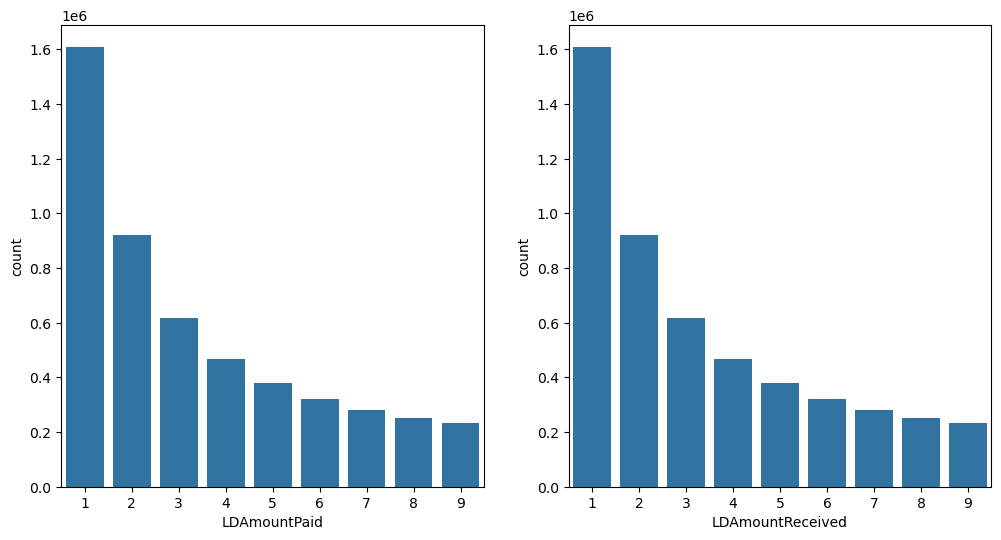

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x="LDAmountPaid", data=df, ax=axes[0])
sns.countplot(x="LDAmountReceived", data=df, ax=axes[1])

In [6]:
features = df.drop(columns='IsLaundering')
labels = df['IsLaundering']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [7]:
# undersampling majority class
train_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)],axis=1)
class_counts = train_df['IsLaundering'].value_counts()
df_majority = train_df[train_df['IsLaundering'] == 0]
df_minority = train_df[train_df['IsLaundering'] == 1]
df_majority_downsampled = resample(df_majority, replace=False, n_samples=class_counts[1])
df_balanced = pd.concat([df_majority_downsampled, df_minority])
X_train, y_train = df_balanced.iloc[:, :-1], df_balanced.iloc[:, [-1]]

### Bayesian Logistic Regression

#### Model 1 - Naive Model

In [8]:
# Build up a formula
formula = [' %s + ' % variable for variable in X_train.columns]
formula.insert(0, 'IsLaundering ~ ')
formula = ' '.join(''.join(formula).split(' ')[:-2])
formula

'IsLaundering ~  FromAccount +  ToAccount +  FromBank +  ToBank +  ReceivingCurrency +  PaymentCurrency +  PaymentFormat +  AmountPaid +  AmountReceived +  LDAmountPaid +  LDAmountReceived'

In [9]:
# Create version of the training data with labels
X_with_labels = X_train.copy()
X_with_labels['IsLaundering'] = y_train

In [10]:
X_with_labels.describe()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,LDAmountPaid,LDAmountReceived,IsLaundering
count,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8.180000e+03,8.180000e+03,8180.000000,8180.000000,8180.000000
mean,239726.843888,211424.442298,1948.030073,2344.669927,8.332274,8.343643,1.742543,2.495862e+07,2.618685e+07,3.287653,3.289487,0.500000
std,162413.717222,144391.482077,3244.852935,2859.762948,4.038161,4.035892,1.856636,1.218741e+09,1.223786e+09,2.474028,2.475371,0.500031
min,68.000000,102.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.360000e-04,2.000000e-06,1.000000,1.000000,0.000000
25%,107904.000000,96375.000000,33.000000,89.000000,4.000000,4.000000,0.000000,6.675025e+02,6.659500e+02,1.000000,1.000000,0.000000
50%,206384.500000,190857.000000,621.000000,785.000000,10.000000,10.000000,1.000000,4.452450e+03,4.456255e+03,2.000000,2.000000,0.500000
75%,338108.250000,290970.750000,1007.000000,6032.250000,12.000000,12.000000,3.000000,1.707100e+04,1.708681e+04,5.000000,5.000000,1.000000
max,515053.000000,515024.000000,29151.000000,28025.000000,14.000000,14.000000,6.000000,8.485314e+10,8.485314e+10,9.000000,9.000000,1.000000


In [11]:
# Building of Bayesian Logistic Regression model
model = bmb.Model(formula, X_with_labels, family="bernoulli")
model

       Formula: IsLaundering ~  FromAccount +  ToAccount +  FromBank +  ToBank +  ReceivingCurrency +  PaymentCurrency +  PaymentFormat +  AmountPaid +  AmountReceived +  LDAmountPaid +  LDAmountReceived
        Family: bernoulli
          Link: p = logit
  Observations: 8180
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.9837)
            FromAccount ~ Normal(mu: 0.0, sigma: 0.0)
            ToAccount ~ Normal(mu: 0.0, sigma: 0.0)
            FromBank ~ Normal(mu: 0.0, sigma: 0.0008)
            ToBank ~ Normal(mu: 0.0, sigma: 0.0009)
            ReceivingCurrency ~ Normal(mu: 0.0, sigma: 0.6191)
            PaymentCurrency ~ Normal(mu: 0.0, sigma: 0.6195)
            PaymentFormat ~ Normal(mu: 0.0, sigma: 1.3466)
            AmountPaid ~ Normal(mu: 0.0, sigma: 0.0)
            AmountReceived ~ Normal(mu: 0.0, sigma: 0.0)
            LDAmountPaid ~ Normal(mu: 0.0, sigma: 1.0106)
            LDAmountReceived ~ Normal(mu: 0

Sampling: [AmountPaid, AmountReceived, FromAccount, FromBank, Intercept, LDAmountPaid, LDAmountReceived, PaymentCurrency, PaymentFormat, ReceivingCurrency, ToAccount, ToBank]


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'FromAccount'}>,
        <Axes: title={'center': 'ToAccount'}>],
       [<Axes: title={'center': 'FromBank'}>,
        <Axes: title={'center': 'ToBank'}>,
        <Axes: title={'center': 'ReceivingCurrency'}>],
       [<Axes: title={'center': 'PaymentCurrency'}>,
        <Axes: title={'center': 'PaymentFormat'}>,
        <Axes: title={'center': 'AmountPaid'}>],
       [<Axes: title={'center': 'AmountReceived'}>,
        <Axes: title={'center': 'LDAmountPaid'}>,
        <Axes: title={'center': 'LDAmountReceived'}>]], dtype=object)

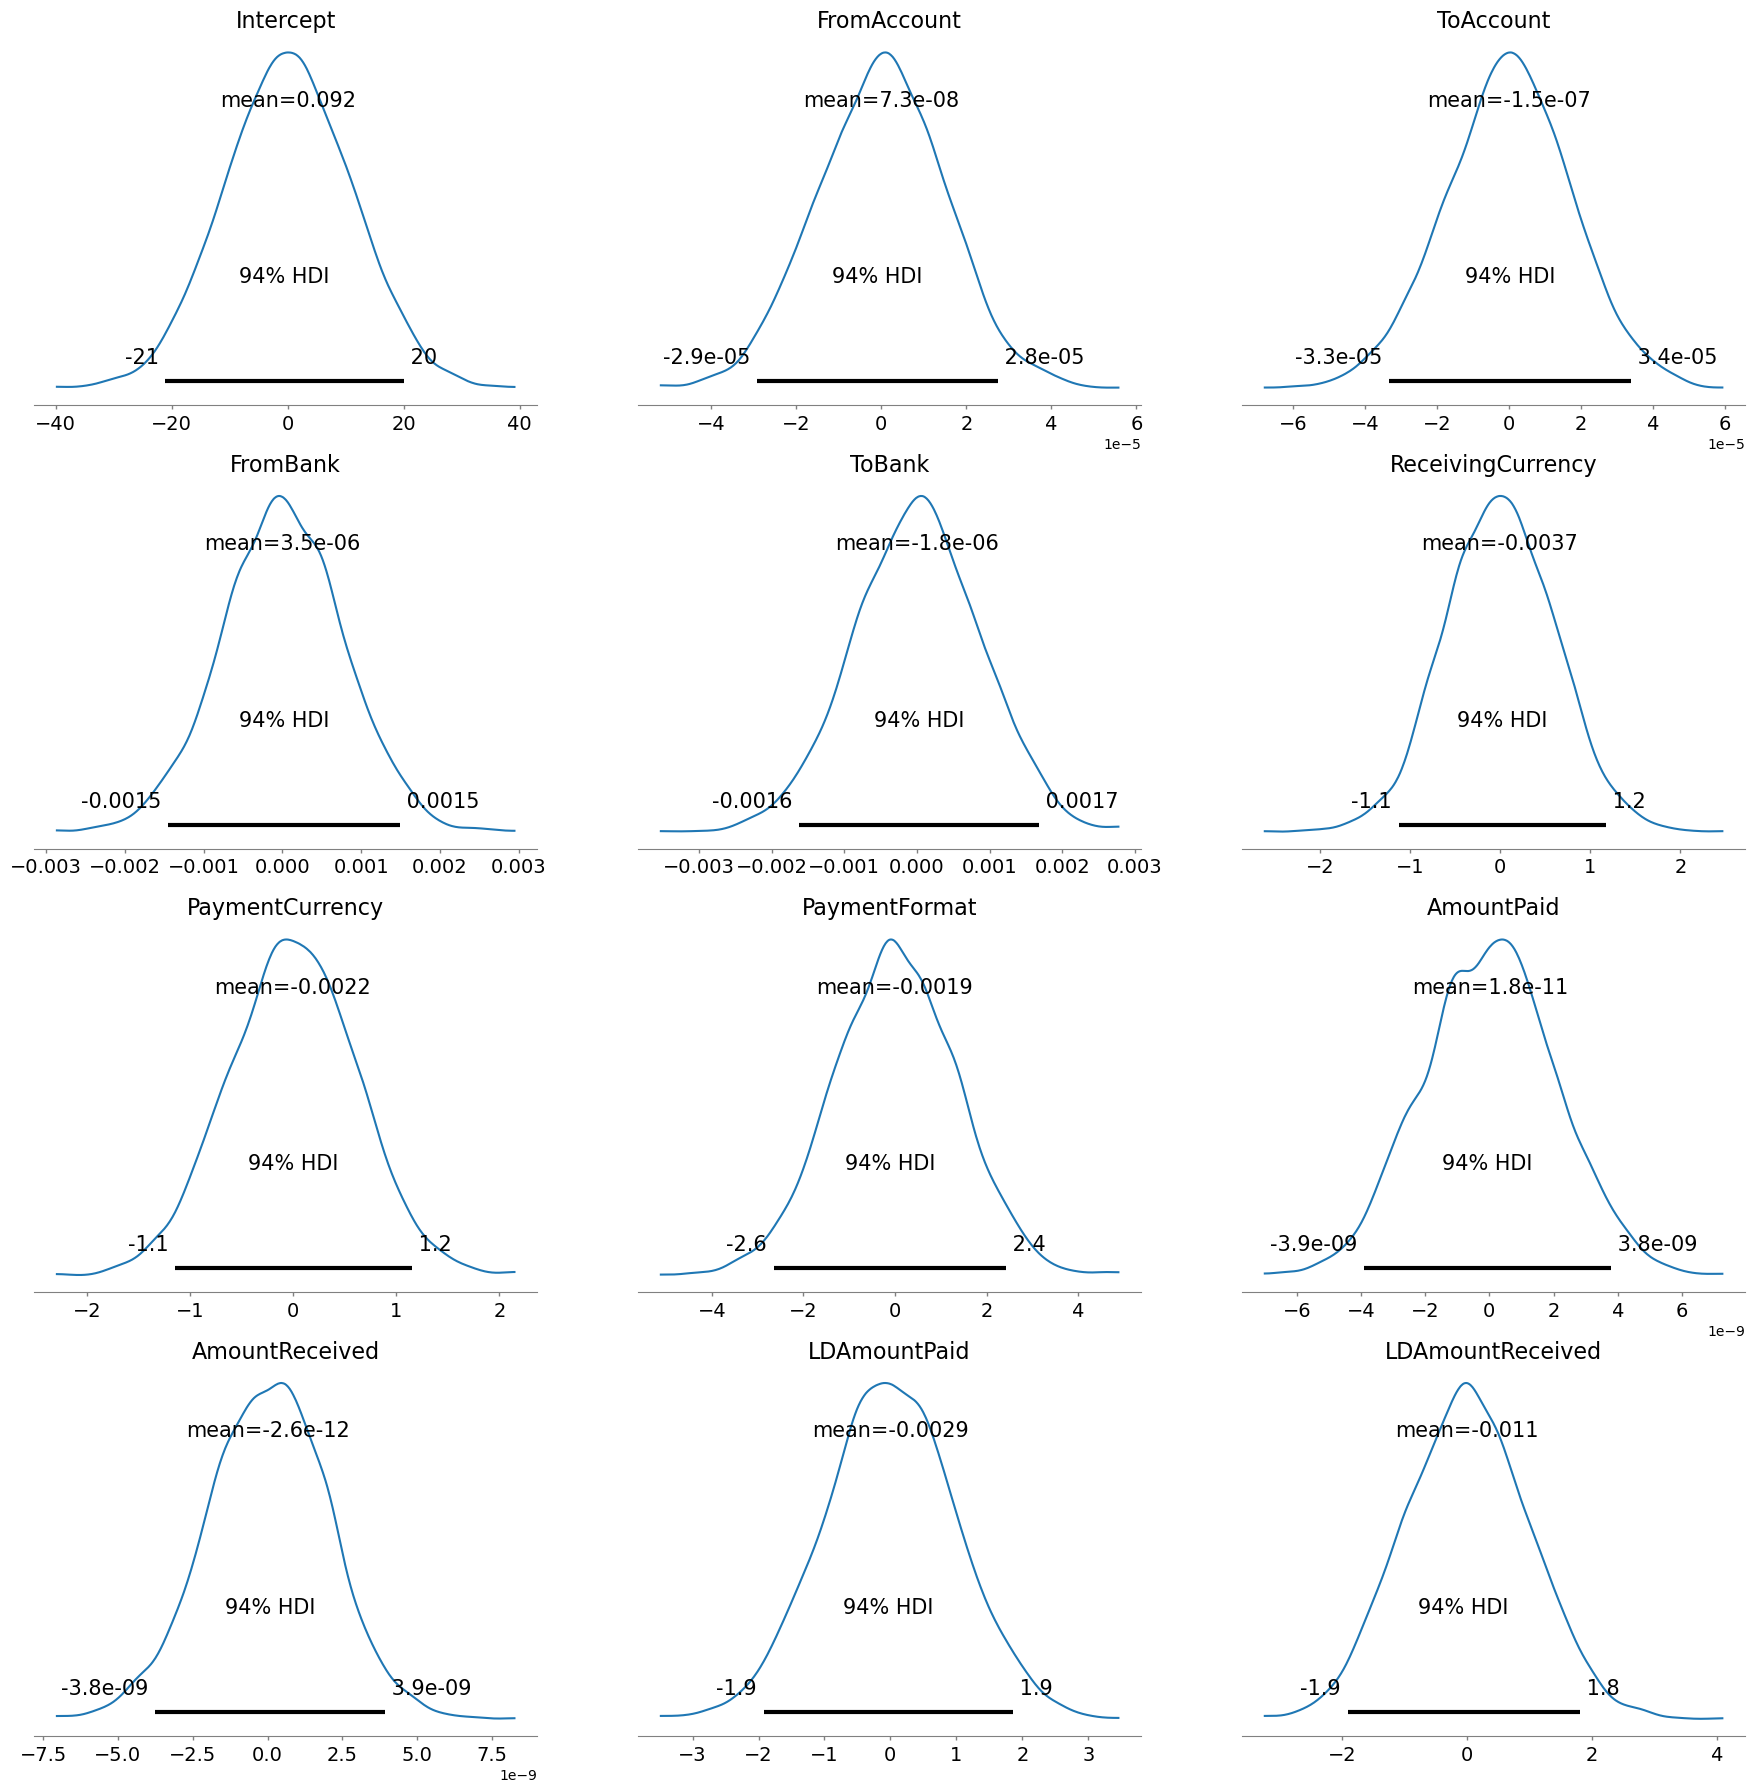

In [12]:
# Plot marginal priors of the built model
model.build()
model.plot_priors()

In [13]:
# fit the model
results = model.fit(draws=1000, chains=2, inference_method='nuts_blackjax', idata_kwargs={"log_likelihood": True})

Modeling the probability that IsLaundering==1
Compiling...
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Compilation time = 0:00:01.086178
Sampling...
Sampling time = 0:00:09.278103
Transforming variables...
Transformation time = 0:00:00.089906
Computing Log Likelihood...
Log Likelihood time = 0:00:00.526254


In [14]:
results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'FromAccount'}>,
        <Axes: title={'center': 'FromAccount'}>],
       [<Axes: title={'center': 'ToAccount'}>,
        <Axes: title={'center': 'ToAccount'}>],
       [<Axes: title={'center': 'FromBank'}>,
        <Axes: title={'center': 'FromBank'}>],
       [<Axes: title={'center': 'ToBank'}>,
        <Axes: title={'center': 'ToBank'}>],
       [<Axes: title={'center': 'ReceivingCurrency'}>,
        <Axes: title={'center': 'ReceivingCurrency'}>],
       [<Axes: title={'center': 'PaymentCurrency'}>,
        <Axes: title={'center': 'PaymentCurrency'}>],
       [<Axes: title={'center': 'PaymentFormat'}>,
        <Axes: title={'center': 'PaymentFormat'}>],
       [<Axes: title={'center': 'AmountPaid'}>,
        <Axes: title={'center': 'AmountPaid'}>],
       [<Axes: title={'center': 'AmountReceived'}>,
        <Axes: title={'center': 'AmountReceived'}>],
      

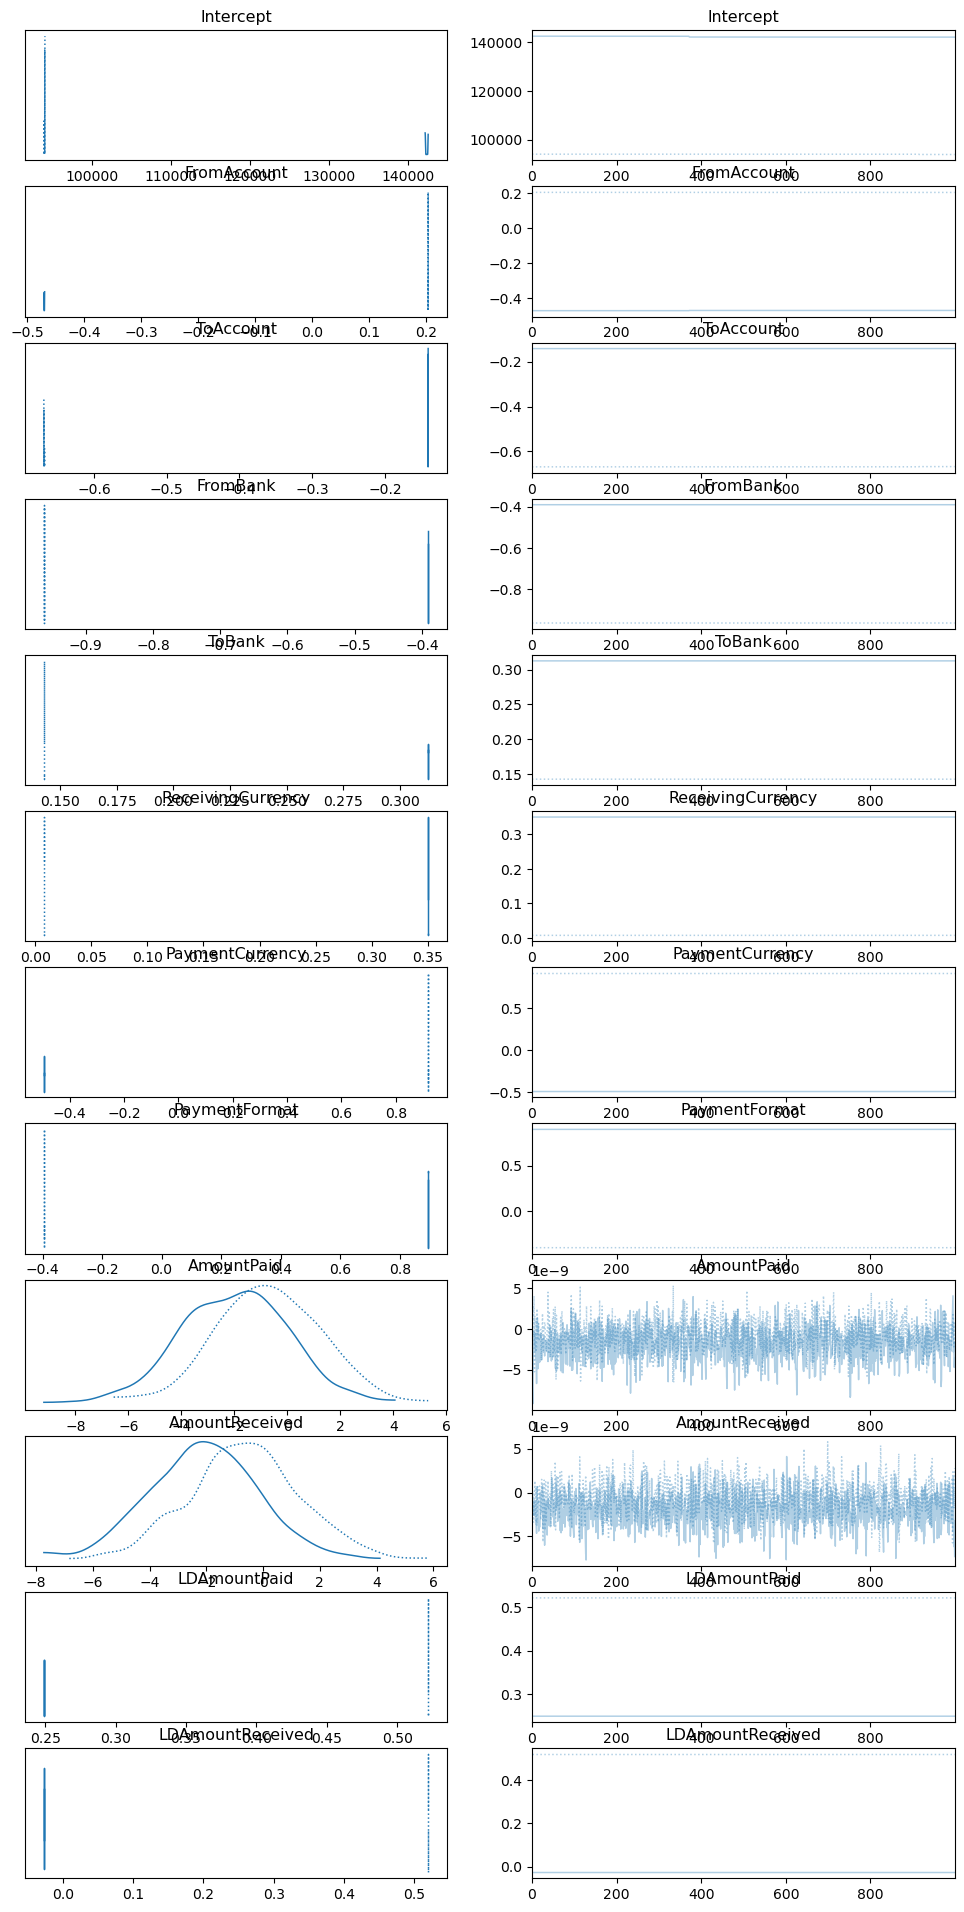

In [15]:
# traceplots and density estimates for the posteriors
az.plot_trace(results, compact=True)

In [16]:
# summary of the posteriors
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,118212.496,24144.221,94070.590,142579.130,17004.052,14384.631,2.0,11.0,3.04
FromAccount,-0.133,0.337,-0.470,0.204,0.237,0.201,2.0,11.0,3.04
ToAccount,-0.405,0.264,-0.669,-0.141,0.186,0.157,2.0,11.0,3.04
FromBank,-0.676,0.286,-0.962,-0.391,0.201,0.170,2.0,11.0,2.69
ToBank,0.228,0.085,0.143,0.312,0.060,0.050,3.0,16.0,2.22
ReceivingCurrency,0.179,0.172,0.008,0.351,0.121,0.102,3.0,15.0,2.39
PaymentCurrency,0.212,0.707,-0.495,0.919,0.498,0.421,3.0,11.0,2.04
PaymentFormat,0.250,0.646,-0.396,0.895,0.455,0.385,3.0,28.0,1.94
AmountPaid,-0.000,0.000,-0.000,0.000,0.000,0.000,21.0,1344.0,1.07
AmountReceived,-0.000,0.000,-0.000,0.000,0.000,0.000,16.0,1103.0,1.09


<Axes: >

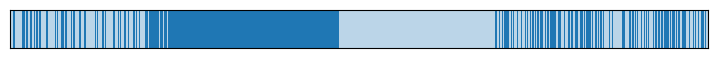

In [17]:
model.predict(results, kind="pps")
az.plot_separation(results, y='IsLaundering', figsize=(9,0.5)) # separation plot to assess model performance

#### Model 2

In [18]:
formula = '''IsLaundering ~  0 + FromAccount +  ToAccount 
                            +  FromBank +  ToBank 
                            +  ReceivingCurrency +  PaymentCurrency 
                            +  PaymentFormat +  AmountPaid +  AmountReceived 
                            +  LDAmountPaid +  LDAmountReceived
'''

model2 = bmb.Model(formula, X_with_labels, family="bernoulli")
model2

       Formula: IsLaundering ~  0 + FromAccount +  ToAccount 
                            +  FromBank +  ToBank 
                            +  ReceivingCurrency +  PaymentCurrency 
                            +  PaymentFormat +  AmountPaid +  AmountReceived 
                            +  LDAmountPaid +  LDAmountReceived

        Family: bernoulli
          Link: p = logit
  Observations: 8180
        Priors: 
    target = p
        Common-level effects
            FromAccount ~ Normal(mu: 0.0, sigma: 0.0)
            ToAccount ~ Normal(mu: 0.0, sigma: 0.0)
            FromBank ~ Normal(mu: 0.0, sigma: 0.0008)
            ToBank ~ Normal(mu: 0.0, sigma: 0.0009)
            ReceivingCurrency ~ Normal(mu: 0.0, sigma: 0.6191)
            PaymentCurrency ~ Normal(mu: 0.0, sigma: 0.6195)
            PaymentFormat ~ Normal(mu: 0.0, sigma: 1.3466)
            AmountPaid ~ Normal(mu: 0.0, sigma: 0.0)
            AmountReceived ~ Normal(mu: 0.0, sigma: 0.0)
            LDAmountPaid ~ Normal(mu

Sampling: [AmountPaid, AmountReceived, FromAccount, FromBank, LDAmountPaid, LDAmountReceived, PaymentCurrency, PaymentFormat, ReceivingCurrency, ToAccount, ToBank]


array([[<Axes: title={'center': 'FromAccount'}>,
        <Axes: title={'center': 'ToAccount'}>,
        <Axes: title={'center': 'FromBank'}>],
       [<Axes: title={'center': 'ToBank'}>,
        <Axes: title={'center': 'ReceivingCurrency'}>,
        <Axes: title={'center': 'PaymentCurrency'}>],
       [<Axes: title={'center': 'PaymentFormat'}>,
        <Axes: title={'center': 'AmountPaid'}>,
        <Axes: title={'center': 'AmountReceived'}>],
       [<Axes: title={'center': 'LDAmountPaid'}>,
        <Axes: title={'center': 'LDAmountReceived'}>, <Axes: >]],
      dtype=object)

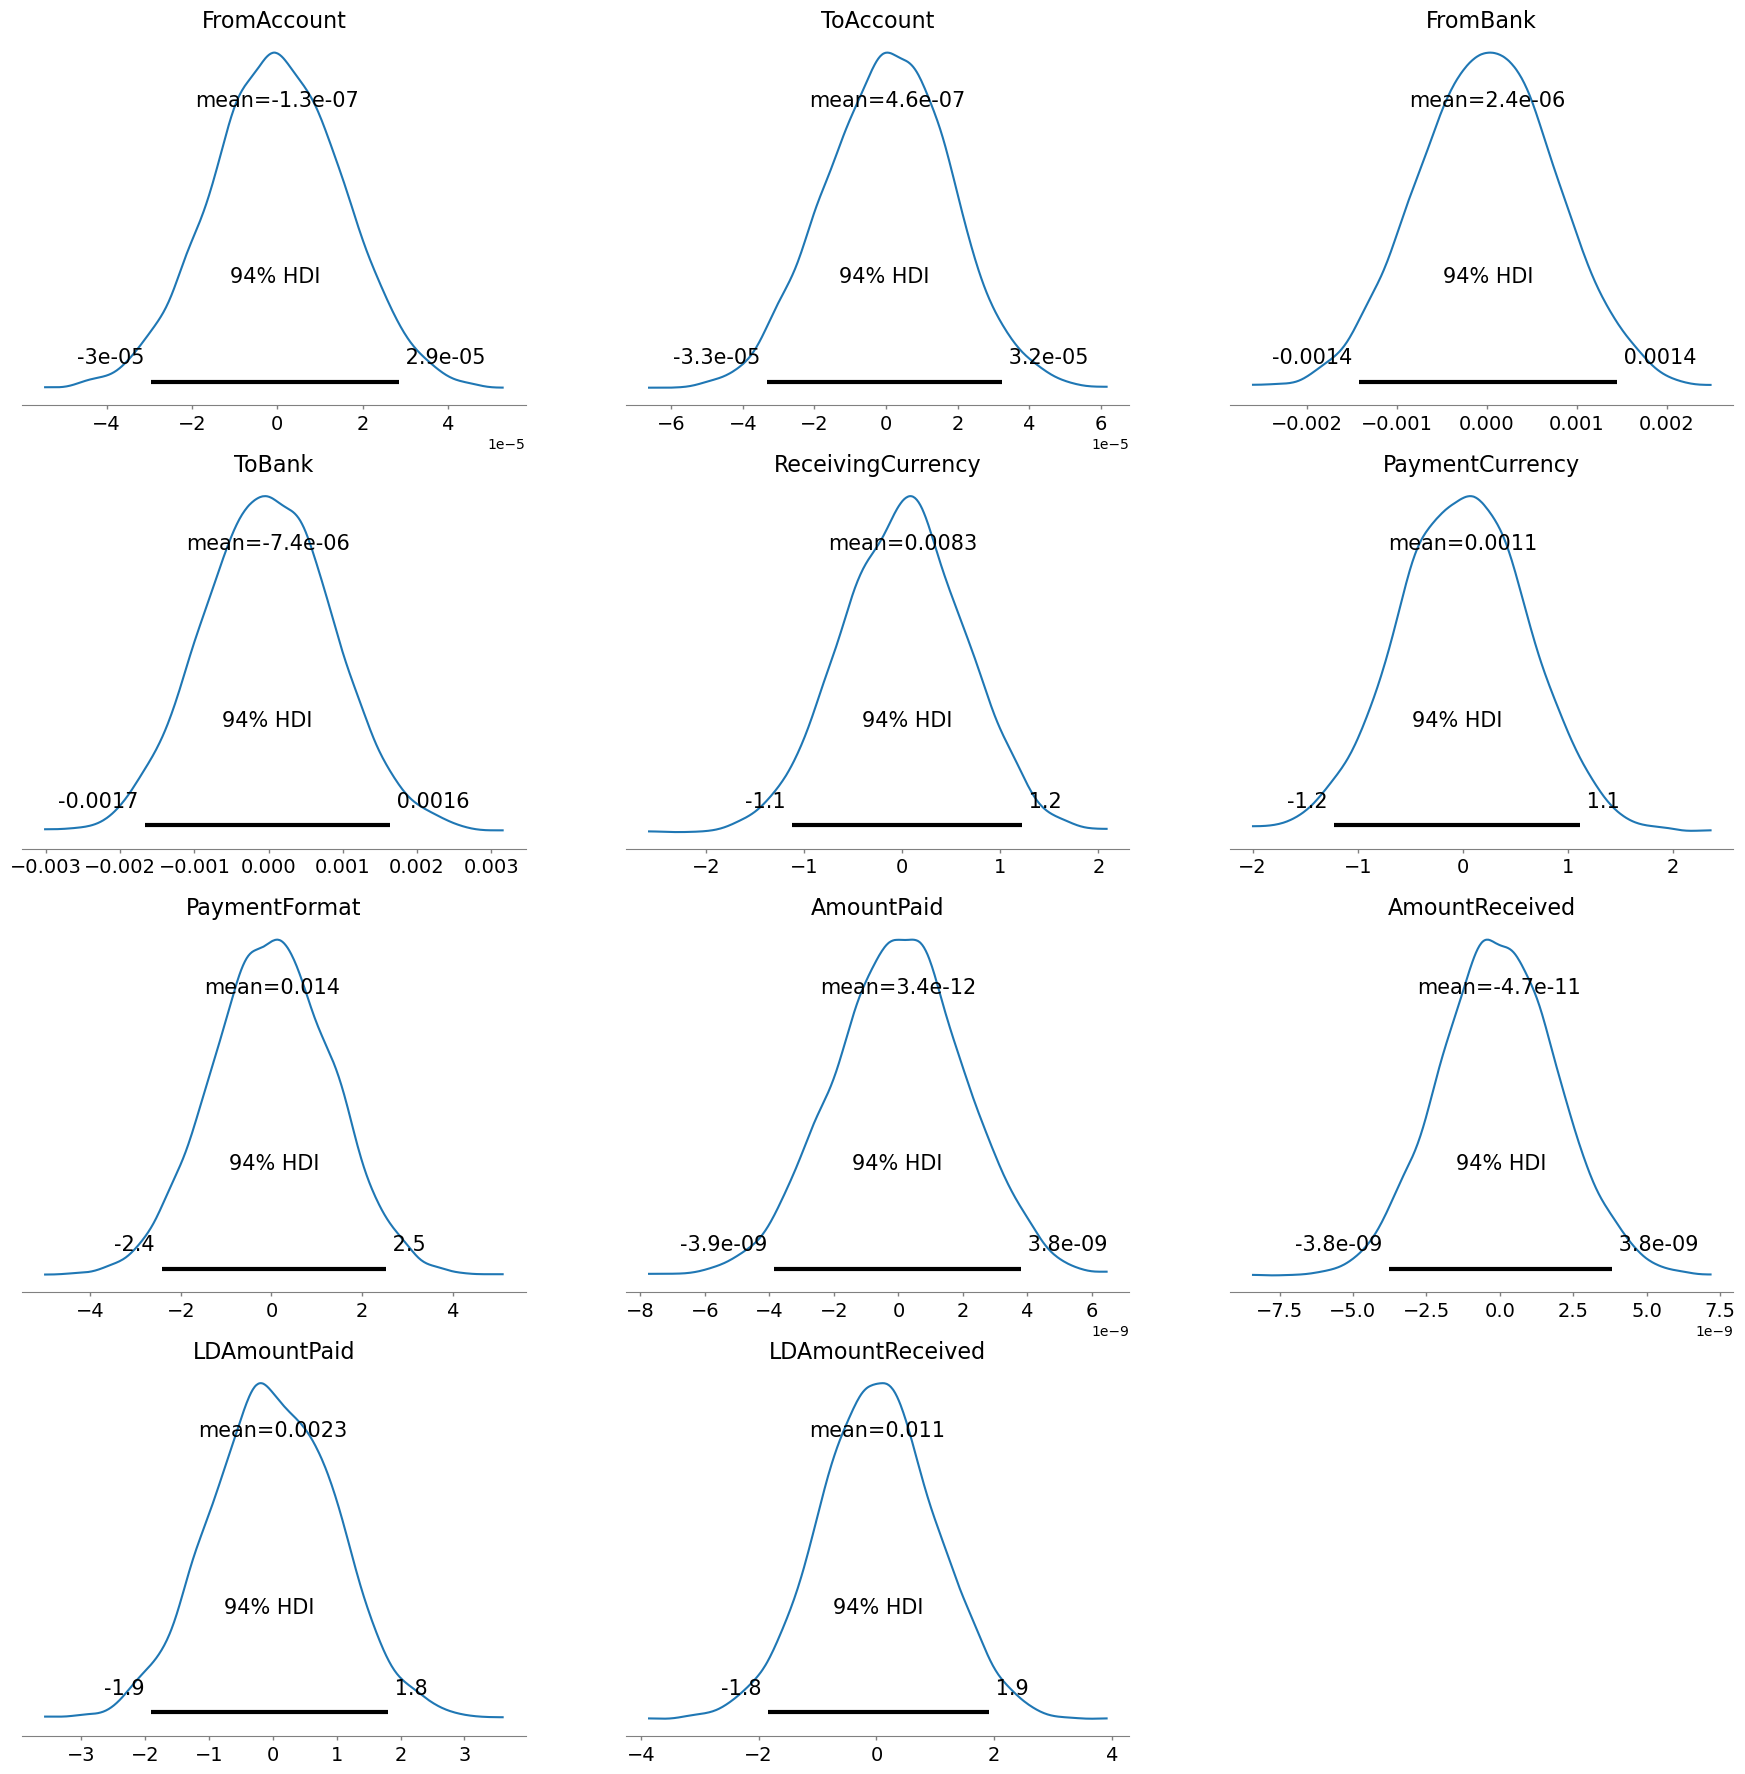

In [19]:
# Plot marginal priors of the built model
model2.build()
model2.plot_priors()

In [20]:
# fit the model
results2 = model2.fit(draws=1000, chains=2, inference_method='nuts_blackjax', idata_kwargs={"log_likelihood": True})

Modeling the probability that IsLaundering==1
Compiling...
Compilation time = 0:00:00.522765
Sampling...
Sampling time = 0:03:07.122338
Transforming variables...
Transformation time = 0:00:00.068567
Computing Log Likelihood...
Log Likelihood time = 0:00:00.435933


### Model Comparison

In [21]:
models_dict = {
    "model": results,
    "model2": results2
}
df_compare = az.compare(models_dict)
df_compare

/home/bernard/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/bernard/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model,0,-223233.796376,148576.530574,0.000000,0.638634,2339.691320,0.000000,True,log
model2,1,-264329.547044,219822.828685,41095.750668,0.361366,1938.832916,3130.983564,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

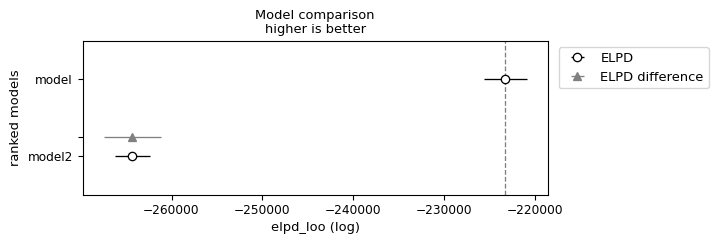

In [22]:
az.plot_compare(df_compare, insample_dev=False)

### Model Prediction

In [ ]:
# bmb.interpret.plot_predictions(model, results, average_by=True)